In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime

# 1. Create fake data for 1 bunch 

In [156]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.
bunch_spacing      = 25e-9 # bunch spacing
total_nb_bunches   = 3564 # total number of bunches in the LHC

signal1_frequency  = 3000.    # Hz
signal1_amplitude  = 5.0     # assuming um
signal1_color      = 'r'
signal2_frequency  = 8000.    # Hz
signal2_amplitude  = 2.5 
signal2_color      = 'b'
signal3_frequency  = 16000.    # Hz
signal3_amplitude  = 1.0 
signal3_color      = 'g'

time               = np.arange(0, 1, 1/sampling_frequency) # signal of 1 sec. duration

In [157]:
sampling_time 

8.892445867235783e-05

In [98]:
signal = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*time)

signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization
signal_freqs = np.linspace(0, sampling_frequency, len(time))

In [99]:
def get_aliased_frequency(freq):
    while freq > sampling_frequency / 2:
        freq = abs(sampling_frequency-freq)
    return freq

3000.0 will appear as 3000.0 Hz, r
8000.0 will appear as 3245.5 Hz, b
16000.0 will appear as 4754.5 Hz, g


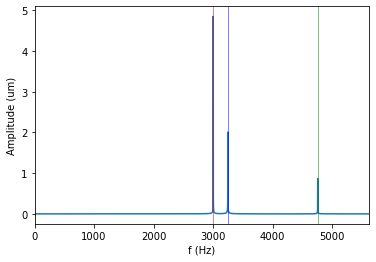

In [47]:
fig, ax = plt.subplots()
plt.plot(signal_freqs, signal_fft)
plt.xlim(0, nyquist_frequency)
plt.ylabel("Amplitude (um)")
plt.xlabel("f (Hz)")

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    # find aliased frequencies if any
    aliased_frequency = get_aliased_frequency(freq)
    print(f"{freq} will appear as {aliased_frequency} Hz, {color}")
    plt.axvline(aliased_frequency, c=color, lw=0.5)
    

# 2. Create fake data for several bunches

## Periodic filling scheme

In [48]:
# periodc filling scheme

nb_bunches = 3
deltaT_s   = total_nb_bunches/nb_bunches * bunch_spacing 
signal_freqs = np.linspace(0, sampling_frequency, len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = nb_bunch * deltaT_s
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs*time_delay))

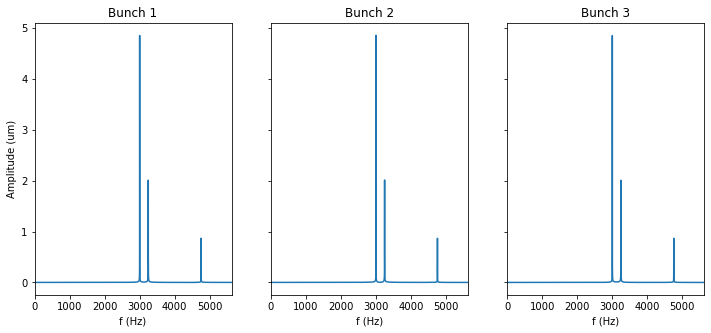

In [49]:
fig, ax = plt.subplots(figsize=(12,5), ncols=3, sharex=True, sharey=True)

plt.xlim(0, nyquist_frequency)
plt.sca(ax[0])
plt.ylabel("Amplitude (um)")

for nb_bunch in range(nb_bunches):
    plt.sca(ax[nb_bunch])
    plt.xlabel("f (Hz)")
    plt.plot(signal_freqs,abs(fft_bunch[nb_bunch]))
    plt.title(f"Bunch {nb_bunch+1}")




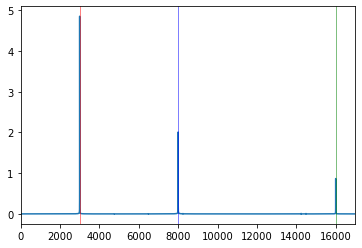

In [50]:
nb_bunches = 3
filling_pattern = [0, 1*total_nb_bunches/3, 2*total_nb_bunches/3]
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




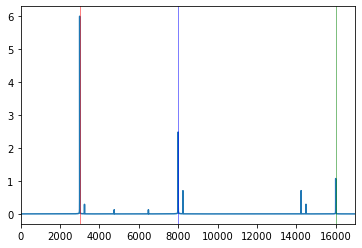

In [51]:
# periodic filling scheme but bunch intensity variations

nb_bunches = 3
filling_pattern = [0, 1*total_nb_bunches/3, 2*total_nb_bunches/3]
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

amplitude = [1., 1.2, 1.5]                   

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    signal_bunch[nb_bunch] *= amplitude[nb_bunch]
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)





## Half-full machine

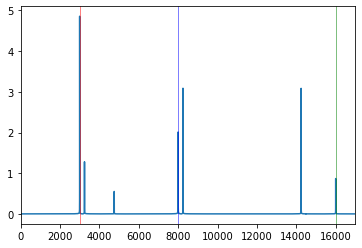

In [52]:
nb_bunches = total_nb_bunches//2
filling_pattern = np.arange(0, nb_bunches)
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    #print(nb_bunch)
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)



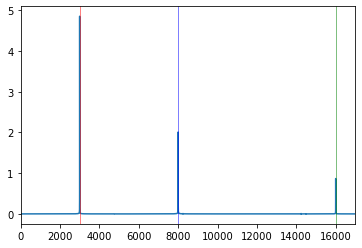

In [126]:
# full machine but bunch intensity variations

import random

nb_bunches = total_nb_bunches


filling_pattern = np.arange(0, nb_bunches)
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []


for nb_bunch in range(nb_bunches):
#for nb_bunch in range(3):

    #print(nb_bunch)
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)

    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)





In [127]:
nb_bunches

3564

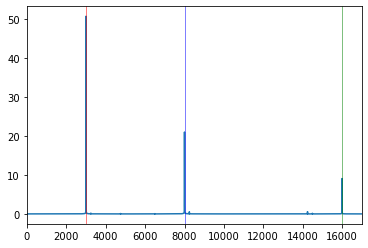

In [54]:
# full machine but bunch intensity variations

import random

nb_bunches = total_nb_bunches
filling_pattern = np.arange(0, nb_bunches)
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

random_amplitudes = [random.uniform(1, 20) for i in range(3564)]

for nb_bunch in range(nb_bunches):
    #print(nb_bunch)
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    signal_bunch[nb_bunch]*=random_amplitudes[nb_bunch]
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




## Random filling scheme

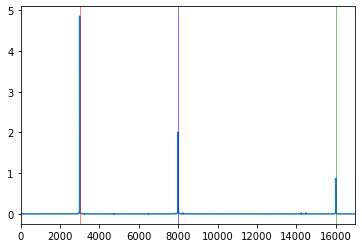

In [55]:
import random

nb_bunches = 2000

filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




### Real filling scheme only for the number of bunches > 0, 2405

1) 2 bunches close to each other [0,1]

In [158]:
filling_pattern = pd.read_parquet('/eos/home-i01/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/fillingall.parquet', engine='pyarrow')
filling_pattern = filling_pattern['Filling scheme']

print(filling_pattern[1776])
bunches = np.where(filling_pattern>0)[0]
print(bunches[:10])
#bunches_used = np.array([bunches[0], bunches[1]])
number = (3564 - bunches[0])/2
closest = min(bunches, key=lambda x: abs(x - number))
bunches_used = np.array([bunches[0], closest])

print(bunches[0], closest)
filling_pattern = bunches_used
print(filling_pattern)

1.0
[12 13 14 15 16 17 18 19 20 21]
12 1776
[  12 1776]


In [159]:

number = (3564 - bunches[0])/3
number2 = 2* (3564 - bunches[0])/3
closest = min(bunches, key=lambda x: abs(x - number))
closest2 = min(bunches, key=lambda x: abs(x - number2))
bunches_used = np.array([bunches[0], closest, closest2])
filling_pattern = bunches_used


In [167]:
tot_num = 100


number = [''] * tot_num
closest = [''] * tot_num

for i in range(tot_num):
    number[i] = (i + 1) * (3564 - 12)/tot_num
    closest[i] = min(bunches, key=lambda x: abs(x - number[i]))
    if j in closest == j+1:
        clostest[j] = bunch
    
print(number)
print(closest)
#for 5 
#number = [710.4, 1420.8, 2131.2, 2841.6, 3552.0]
#closest = [712, 1421, 2131, 2842, 3353]

#for 10
#[355.2, 710.4, 1065.6, 1420.8, 1776.0, 2131.2, 2486.4, 2841.6, 3196.8, 3552.0]
#[355, 712, 1066, 1421, 1776, 2131, 2486, 2842, 3197, 3353]

#for 20
#[177.6, 355.2, 532.8, 710.4, 888.0, 1065.6, 1243.2, 1420.8, 1598.4, 1776.0, 1953.6, 2131.2, 2308.8, 2486.4, 2664.0, 2841.6, 3019.2, 3196.8, 3374.4, 3552.0]
#[178, 355, 533, 712, 888, 1066, 1242, 1421, 1596, 1776, 1954, 2131, 2309, 2486, 2787, 2842, 3019, 3197, 3353, 3353]


[35.52, 71.04, 106.56, 142.08, 177.6, 213.12, 248.64, 284.16, 319.68, 355.2, 390.72, 426.24, 461.76, 497.28, 532.8, 568.32, 603.84, 639.36, 674.88, 710.4, 745.92, 781.44, 816.96, 852.48, 888.0, 923.52, 959.04, 994.56, 1030.08, 1065.6, 1101.12, 1136.64, 1172.16, 1207.68, 1243.2, 1278.72, 1314.24, 1349.76, 1385.28, 1420.8, 1456.32, 1491.84, 1527.36, 1562.88, 1598.4, 1633.92, 1669.44, 1704.96, 1740.48, 1776.0, 1811.52, 1847.04, 1882.56, 1918.08, 1953.6, 1989.12, 2024.64, 2060.16, 2095.68, 2131.2, 2166.72, 2202.24, 2237.76, 2273.28, 2308.8, 2344.32, 2379.84, 2415.36, 2450.88, 2486.4, 2521.92, 2557.44, 2592.96, 2628.48, 2664.0, 2699.52, 2735.04, 2770.56, 2806.08, 2841.6, 2877.12, 2912.64, 2948.16, 2983.68, 3019.2, 3054.72, 3090.24, 3125.76, 3161.28, 3196.8, 3232.32, 3267.84, 3303.36, 3338.88, 3374.4, 3409.92, 3445.44, 3480.96, 3516.48, 3552.0]


AttributeError: 'list' object has no attribute 'unique'

[   45.5    95.5   145.5   195.5   245.5   295.5   345.5   395.5   445.5
   495.5   545.5   595.5   645.5   695.5   745.5   795.5   845.5   895.5
   945.5   995.5  1045.5  1095.5  1145.5  1195.5  1245.5  1295.5  1345.5
  1395.5  1445.5  1495.5  1545.5  1595.5  1645.5  1695.5  1745.5  1795.5
  1845.5  1895.5  1945.5  1995.5  2045.5  2095.5  2145.5  2195.5  2245.5
  2295.5  2345.5  2395.5  2445.5  2495.5  2545.5  2595.5  2645.5  2695.5
  2745.5  2795.5  2845.5  2895.5  2945.5  2995.5  3045.5  3095.5  3145.5
  3195.5  3245.5  3295.5  3345.5  3395.5  3445.5  3495.5  3545.5  3595.5
  3645.5  3695.5  3745.5  3795.5  3845.5  3895.5  3945.5  3995.5  4045.5
  4095.5  4145.5  4195.5  4245.5  4295.5  4345.5  4395.5  4445.5  4495.5
  4545.5  4595.5  4645.5  4695.5  4745.5  4795.5  4845.5  4895.5  4945.5
  4995.5  5045.5  5095.5  5145.5  5195.5  5245.5  5295.5  5345.5  5395.5
  5445.5  5495.5  5545.5  5595.5  5645.5  5695.5  5745.5  5795.5  5845.5
  5895.5  5945.5  5995.5  6045.5  6095.5  6145.5  6

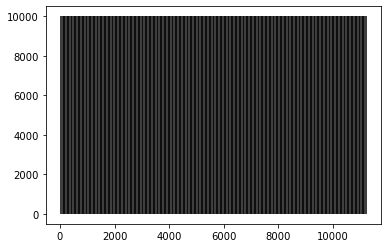

In [164]:
x = np.arange(0,11245.5,50)
y = abs(np.arange(-11245.5+50, 0, 50))[::-1]
print(y)
plt.vlines(y, 0,10000, color = 'black')

In [102]:
print(filling_pattern)
np.diff(filling_pattern)
3564 -2368+12

[  12 1184 2368]


1208

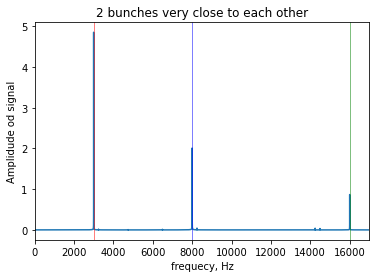

In [94]:
#MODIFY for custom filling scheme

import random

nb_bunches = len(bunches_used)

#filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)
    plt.title('2 bunches very close to each other')
    plt.xlabel('frequecy, Hz')
    plt.ylabel('Amplidude od signal')



2) 2 bunches on the half path of circumfence [0,1200]

In [37]:
filling_pattern = pd.read_parquet('/eos/home-i01/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/filling.parquet', engine='pyarrow')
filling_pattern = filling_pattern['Filling scheme']
bunches = np.where(filling_pattern>0)[0]
bunches_used = np.array([bunches[0], bunches[1200]])
print(len(bunches_used))
filling_pattern = bunches_used

2


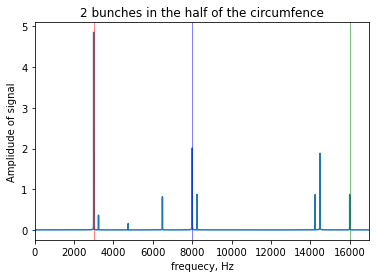

In [38]:
#MODIFY for custom filling scheme

import random

nb_bunches = len(np.where(filling_pattern>0)[0])

#filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)
    plt.title('2 bunches in the half of the circumfence')
    plt.xlabel('frequecy, Hz')
    plt.ylabel('Amplidude of signal')




3) 3 bunches ~ equal spacing [0,800,1600]

In [40]:
filling_pattern = pd.read_parquet('/eos/home-i01/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/filling.parquet', engine='pyarrow')

filling_pattern = filling_pattern['Filling scheme']
bunches = np.where(filling_pattern>0)[0]
bunches_used = np.array([bunches[0], bunches[800], bunches[1600]])
print(len(bunches_used))
filling_pattern = bunches_used

3


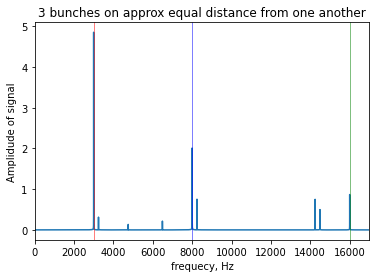

In [41]:
#MODIFY for custom filling scheme

import random

nb_bunches = len(np.where(filling_pattern>0)[0])

#filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)
    plt.title('3 bunches on approx equal distance from one another')
    plt.xlabel('frequecy, Hz')
    plt.ylabel('Amplidude of signal')




4) Random picking of bunches

In [73]:
filling_pattern = pd.read_parquet('/eos/home-i01/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/filling.parquet', engine='pyarrow')

filling_pattern = filling_pattern['Filling scheme']
bunches = np.where(filling_pattern>0)[0]
#bunches_used = np.array(random.choices(bunches, k=1000))   #random choice
bunches_used = np.array(bunches)                       #every second value
print(len(bunches_used))
filling_pattern = bunches_used

2405


In [74]:
filling_pattern

array([  12,   13,   14, ..., 3351, 3352, 3353])

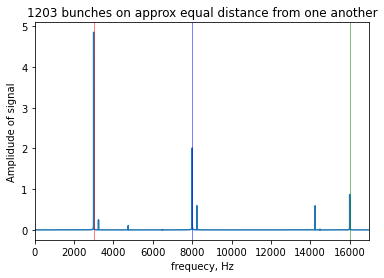

In [75]:
#MODIFY for custom filling scheme

import random

nb_bunches = len(bunches_used)

#filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)
    plt.title('1203 bunches on approx equal distance from one another')
    plt.xlabel('frequecy, Hz')
    plt.ylabel('Amplidude of signal')




### Real filling scheme all 3564

In [66]:
#MODIFY for custom filling scheme

import random

#nb_bunches = len(np.where(filling_pattern>0)[0])
nb_bunches = 3564
#filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




IndexError: index 2405 is out of bounds for axis 0 with size 2405

In [35]:
print(len(np.where(filling_pattern>0)[0]))

2405


In [29]:
print(len(filling_pattern))

3564


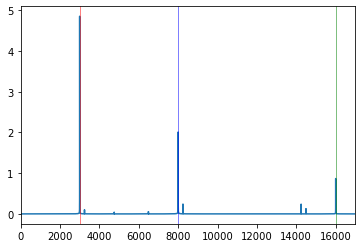

In [42]:
import random

nb_bunches = 50

filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)





In [43]:
print(filling_pattern)

[2761, 2904, 559, 1618, 550, 1329, 1790, 2061, 396, 3051, 3411, 372, 3430, 2269, 959, 443, 283, 1726, 3207, 1782, 1438, 3326, 2940, 1398, 668, 3336, 2818, 1005, 2567, 1629, 1778, 2352, 422, 1131, 1467, 3418, 1552, 2473, 993, 2636, 2751, 1707, 310, 864, 2809, 2, 107, 2533, 1058, 892]


# 3. Fake data in h5 format and ADT class

In [57]:
# Create a 2D array with # number of turns as rows and 3564 column 

nb_bunches = 3
filling_pattern = [0, 1*total_nb_bunches//3, 2*total_nb_bunches//3]

fake_data = np.zeros((len(time), total_nb_bunches), dtype='float')

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    fake_data[:, filling_pattern[nb_bunch]] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    
# Save in h5 format compatible with ADTObsBox data
with h5py.File('B1H_Q8_20250618_04h00m05s26426us.h5','w') as f:
    group = f.create_group('B1')
    group.create_dataset(name='horizontal', data=fake_data)

with h5py.File('B1H_Q8_20250618_04h01m05s26426us.h5','w') as f:
    group = f.create_group('B1')
    group.create_dataset(name='horizontal', data=fake_data)
    
with h5py.File('B2H_Q7_20250618_04h04m05s26426us.h5','w') as f:
    group = f.create_group('B2')
    group.create_dataset(name='horizontal', data=fake_data)

filenames_to_consider = ["B1H_Q8_20250618_04h00m05s26426us.h5", "B1H_Q8_20250618_04h01m05s26426us.h5", 'B2H_Q7_20250618_04h04m05s26426us.h5']


In [44]:
data = pd.read_csv('25ns_2744b_2736_2246_2370_240bpi_13inj_800ns_bs200ns_BCMS_5x48b.csv')


In [46]:
data = data.T
#print(data)

In [47]:
b1 = data['B1 filled buckets']
b2 = data['B1 filled buckets']

In [27]:
t = 11245.5*3

33736.5

In [40]:
filling = np.zeros(len(b1))
for i in b:
    filling 

In [ ]:
data[0]

In [2]:
class ADT:
    def __init__(self, filenames):
        df = self.extract_file_info(filenames)
        df.sort_index(inplace=True)
        self.importEmptyDF = {bp: df[df['Beam-Plane'] == bp] for bp in np.unique(df['Beam-Plane'])}

    def extract_file_info(self, filenames):
        beam_planes = []
        pus = []
        times = []
        for file_name in filenames:
            bp, pu, date, time = file_name.split('/')[-1].split('_')
            time = self.fromName2Timestamp(f'{bp}_{pu}_{date}_{time}')
            beam_planes.append(bp)
            pus.append(pu)
            times.append(time)
        return pd.DataFrame({'PU': pus, 'Beam-Plane': beam_planes, 'Path': filenames}, index=np.array(times))

    def fromName2Timestamp(self, current_fileName,tz_start='CET',tz_end='UTC'):
        year = current_fileName.split('_')[-2][0:4]
        month = current_fileName.split('_')[-2][4:6]
        day   = current_fileName.split('_')[-2][6:]
        full_datetime = f'{day}/{month}/{year} ' + current_fileName.split('_')[-1].split('.')[0]
        return pd.Timestamp(datetime.datetime.strptime(full_datetime,"%d/%m/%Y %Hh%Mm%Ss%fus")).tz_localize(tz_start, ambiguous=False).tz_convert(tz_end)

    def loadData(self, fileName):
        fi = h5py.File(fileName, 'r')
        beam, plane = fileName.split('_')[-4].split('/')[-1][:2], fileName.split('_')[-4].split('/')[-1][2:3]
        plane = 'horizontal' if plane == 'H' else 'vertical'
        alldat = fi[beam][plane]
        print('Buffer: Turns = %s, Bunches = %s' % (alldat.shape[0], alldat.shape[1]))
        return alldat[:]
    
    def cmp_fft(self, data, specific_bunch, frev=11245.5, first_bunch_slot=0, bunch_spacing=25e-9, repeat_fft=1):
        fourier =  np.fft.fft(data[:,specific_bunch] )
        fourier = fourier/len(fourier)*2.0
        delay   = (specific_bunch-first_bunch_slot)*bunch_spacing
        fourier = np.concatenate([fourier]*repeat_fft)
        freqs   = np.linspace(0, frev*repeat_fft, len(fourier))
        corrected_fourier = fourier*np.exp(-1j*2.0*np.pi*freqs*delay)
        return pd.Series([freqs, fourier.real, fourier.imag, corrected_fourier.real, corrected_fourier.imag])
    

In [60]:
#from useful_tools.useful_functions import *

B1H B1
Buffer: Turns = 11246, Bunches = 3564
Buffer: Turns = 11246, Bunches = 3564
Bunch slots [   0 1188 2376]
Bunch slots [   0 1188 2376]
B2H B2
Buffer: Turns = 11246, Bunches = 3564
Bunch slots [   0 1188 2376]


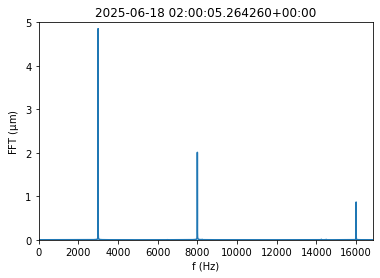

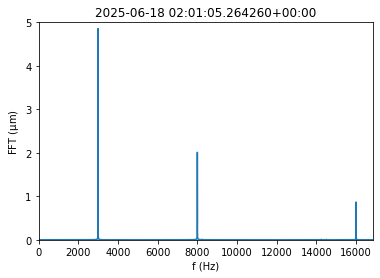

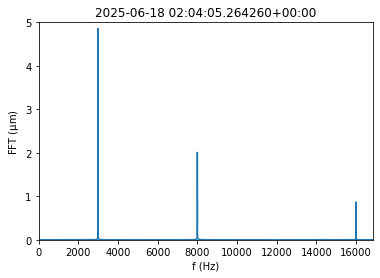

In [61]:
file
adt = ADT(filenames_to_consider)
myDict = adt.importEmptyDF

fourier_tot_real, fourier_tot_imag, fourier_tot_real_corr, fourier_tot_imag_corr, bunch_number_tot, time_tot, pu_tot, beam_plane_tot = [], [], [], [], [], [], [], []

repeat_fft = 3
frev = 11245.5
which_bunch_b1 = 'all'
which_bunch_b2 = 'all'

for beamplane in myDict.keys():
    print(beamplane, beamplane[0:2])
    myDF = myDict[beamplane].copy()
            
    #try:
    if True:
        myDF['Data'] = myDF['Path'].apply(adt.loadData)
      
        for counter in range(len(myDF)):
            data = myDF.iloc[counter]['Data']
            time = myDF.iloc[counter].name
            pu   = myDF.iloc[counter].PU
            current_beamplane = myDF.iloc[counter]['Beam-Plane']
            # for each bunch

            if beamplane[0:2] == 'B1':
                if which_bunch_b1 =='all':
                   idx = np.where(abs(data[0,:])>0.0)[0]
                else:
                    idx = which_bunch_b1

            elif beamplane[0:2] == 'B2':
                if which_bunch_b2 =='all':
                   idx = np.where(abs(data[0,:])>0.0)[0]
                else:
                    idx = which_bunch_b2
            
            print(f"Bunch slots {idx}")
            for idd in idx:
              #try:
              if True:

    
                freqs, fourier_real, fourier_imag, fourier_corr_real, fourier_corr_imag  = adt.cmp_fft(data, specific_bunch=idd, frev=frev, first_bunch_slot=idx[0], bunch_spacing=25e-9, repeat_fft=repeat_fft)
                
                fourier_tot_real.append(fourier_real)
                fourier_tot_imag.append(fourier_imag)
                fourier_tot_real_corr.append(fourier_corr_real)
                fourier_tot_imag_corr.append(fourier_corr_imag)
                
                bunch_number_tot.append(idd)
                time_tot.append(time)
                #freqs_tot.append(freqs)
                pu_tot.append(pu)
                beam_plane_tot.append(current_beamplane) 
              #except:
              #  print('prob') 
    #except:
    #    print('prob, load_data')

dff = pd.DataFrame({'fourier_corr_real': fourier_tot_real_corr, "fourier_corr_imag": fourier_tot_imag_corr,'fourier_real': fourier_tot_real, 'fourier_imag': fourier_tot_imag,  'bunch': bunch_number_tot, 'time': time_tot, 'beam-plane': beam_plane_tot, 'pu': pu_tot})


for key, group in dff.groupby("time"):
    aux = group.apply(lambda x: x.fourier_corr_real + 1j*x.fourier_corr_imag, axis=1).mean()
    
    freqs = np.linspace(0, 11245.5*repeat_fft, len(aux))
    fig, ax = plt.subplots()
    plt.plot(freqs, abs(aux)) 
    plt.xlabel("f (Hz)")
    plt.ylabel(r"FFT ($\rm \mu m$)")
    plt.title(key)
    plt.ylim(0,5.0)
    plt.xlim(0, frev*repeat_fft*0.5)
    

# Non-linear systems and harmonics

/tmp/ipykernel_519/4173981491.py:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))


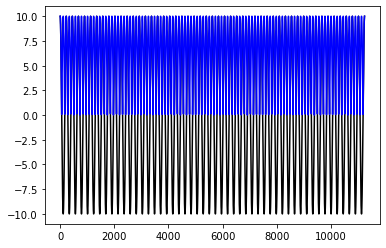

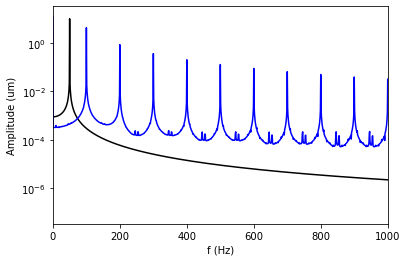

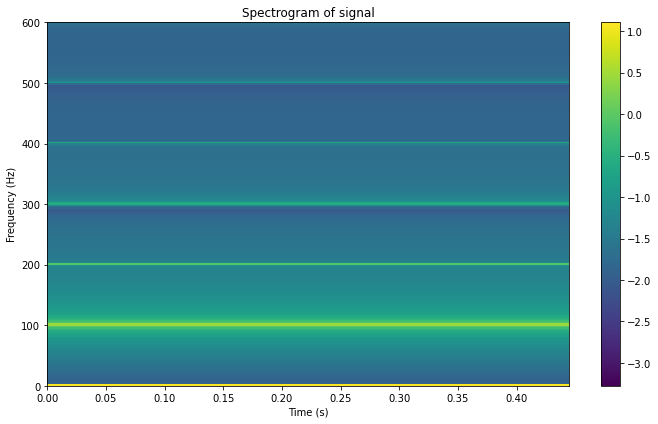

In [62]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.
bunch_spacing      = 25e-9 # bunch spacing
total_nb_bunches   = 3564 # total number of bunches in the LHC


time               = np.arange(0, 1, 1/sampling_frequency) # signal of 1 sec. durtation


signal = 10.0*np.cos(2*np.pi*50.0*time) 

signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization

def transfer_function(x):
    return abs(x)


new_signal = transfer_function(signal)

new_signal_fft = abs(np.fft.fft(new_signal))
new_signal_fft = new_signal_fft/len(new_signal_fft)*2. # normalization


signal_freqs = np.linspace(0, sampling_frequency, len(time))



fig, ax = plt.subplots()
plt.plot(signal, c='k')
plt.plot(new_signal, c='b')

fig, ax = plt.subplots()
plt.semilogy(signal_freqs, signal_fft, c='k')
plt.semilogy(signal_freqs, new_signal_fft, c='b')
plt.xlim(0, 1000)
plt.ylabel("Amplitude (um)")
plt.xlabel("f (Hz)")



chunk_size = 5000
n_chunks = int(len(signal) / chunk_size)
signal_ffts = np.zeros((n_chunks, chunk_size))

new_time = []
for i in range(n_chunks):
    new_time.append(time[i*chunk_size])
    chunk = new_signal[i * chunk_size : (i + 1) * chunk_size]
    signal_ffts[i, :] = np.abs(np.fft.fft(chunk)) / chunk_size * 2

signal_freqs = np.linspace(0, sampling_frequency, chunk_size)
signal_freqs = signal_freqs[:chunk_size//2]

#plt.plot(signal_freqs, abs(signal_ffts[0][:chunk_size//2]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of signal')
plt.colorbar(im)
plt.tight_layout()
plt.ylim(0,600)
plt.show()



/tmp/ipykernel_519/2322008734.py:46: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))


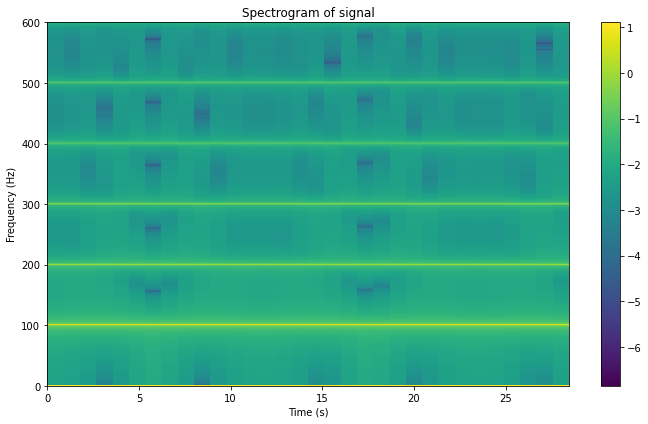

In [63]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.
bunch_spacing      = 25e-9 # bunch spacing
total_nb_bunches   = 3564 # total number of bunches in the LHC


time               = np.arange(0, 30, 1/sampling_frequency) # signal of 1 sec. durtation


signal = 10.0*np.cos(2*np.pi*50.0*time) 

signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization

def transfer_function(x):
    return abs(x)


new_signal = transfer_function(signal)

new_signal_fft = abs(np.fft.fft(new_signal))
new_signal_fft = new_signal_fft/len(new_signal_fft)*2. # normalization


signal_freqs = np.linspace(0, sampling_frequency, len(time))



chunk_size = 10000
n_chunks = int(len(signal) / chunk_size)
signal_ffts = np.zeros((n_chunks, chunk_size))

new_time = []
for i in range(n_chunks):
    new_time.append(time[i*chunk_size])
    chunk = new_signal[i * chunk_size : (i + 1) * chunk_size]
    signal_ffts[i, :] = np.abs(np.fft.fft(chunk)) / chunk_size * 2

signal_freqs = np.linspace(0, sampling_frequency, chunk_size)
signal_freqs = signal_freqs[:chunk_size//2]

#plt.plot(signal_freqs, abs(signal_ffts[0][:chunk_size//2]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of signal')
plt.colorbar(im)
plt.tight_layout()
plt.ylim(0,600)
plt.show()




/tmp/ipykernel_522/2156764828.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))


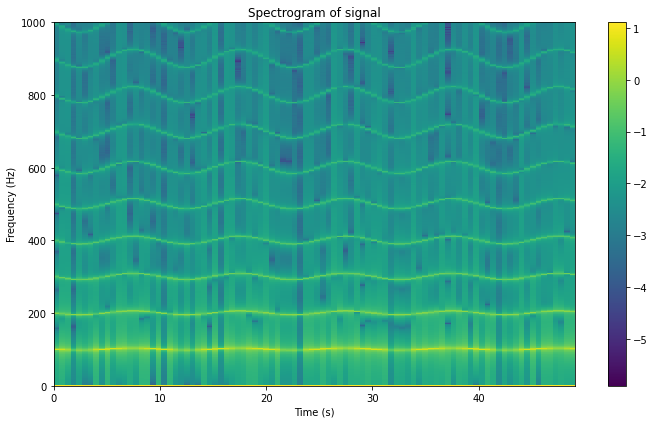

In [129]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.

time               = np.arange(0, 50, 1/sampling_frequency) # signal of 1 sec. durtation

amplitude_FM = 14.0
frequency_FM = 0.1 # Hz

signal_fm = amplitude_FM * np.cos(2.0 * np.pi * frequency_FM * time)


signal = 10.0*np.cos(2.0*np.pi*50.0*time + signal_fm) 


signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization

def transfer_function(x):
    return abs(x)

new_signal = transfer_function(signal)

new_signal_fft = abs(np.fft.fft(new_signal))
new_signal_fft = new_signal_fft/len(new_signal_fft)*2. # normalization


signal_freqs = np.linspace(0, sampling_frequency, len(time))



chunk_size = 6000
n_chunks = int(len(signal) / chunk_size)
signal_ffts = np.zeros((n_chunks, chunk_size))

new_time = []
for i in range(n_chunks):
    new_time.append(time[i*chunk_size])
    chunk = new_signal[i * chunk_size : (i + 1) * chunk_size]
    signal_ffts[i, :] = np.abs(np.fft.fft(chunk)) / chunk_size * 2

signal_freqs = np.linspace(0, sampling_frequency, chunk_size)
signal_freqs = signal_freqs[:chunk_size//2]

#plt.plot(signal_freqs, abs(signal_ffts[0][:chunk_size//2]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
im = ax.pcolormesh(np.array(new_time), signal_freqs, np.log10(signal_ffts[:, :chunk_size//2].T))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of signal')
plt.colorbar(im)
plt.tight_layout()
plt.ylim(0,1000)
plt.show()





In [ ]:
chunk_size

In [ ]:
np.array(new_time).shape, signal_freqs[myfilter].shape, (np.log10(signal_ffts[:, :chunk_size//2].T))[myfilter,:].shape

In [ ]:
signal_ffts[:, :].shape

/tmp/ipykernel_522/3480399676.py:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.array(new_time), signal_freqs[myfilter], np.log10(signal_ffts[:, :chunk_size//2].T)[myfilter, :])


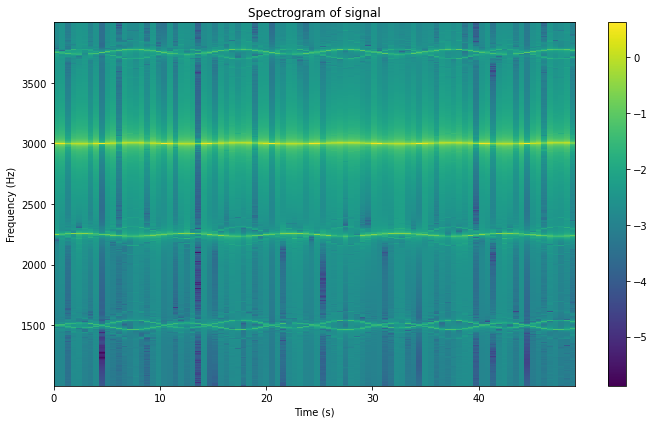

In [130]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.

time               = np.arange(0, 50, 1/sampling_frequency) # signal of 1 sec. duration

amplitude_FM = 20.0
frequency_FM = 0.1 # Hz

signal_fm = amplitude_FM * np.cos(2.0 * np.pi * frequency_FM * time)


signal = 10.0*np.cos(2.0*np.pi*1500.0*time + signal_fm) 


signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization

def transfer_function(x):
    return abs(x)

new_signal = transfer_function(signal)

new_signal_fft = abs(np.fft.fft(new_signal))
new_signal_fft = new_signal_fft/len(new_signal_fft)*2. # normalization


signal_freqs = np.linspace(0, sampling_frequency, len(time))



chunk_size = 6000
n_chunks = int(len(signal) / chunk_size)
signal_ffts = np.zeros((n_chunks, chunk_size))

new_time = []
for i in range(n_chunks):
    new_time.append(time[i*chunk_size])
    chunk = new_signal[i * chunk_size : (i + 1) * chunk_size]
    signal_ffts[i, :] = np.abs(np.fft.fft(chunk)) / chunk_size * 2

signal_freqs = np.linspace(0, sampling_frequency, chunk_size)
signal_freqs = signal_freqs[:chunk_size//2]

#plt.plot(signal_freqs, abs(signal_ffts[0][:chunk_size//2]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
myfilter = (signal_freqs>1000) & (signal_freqs<4000) 
im = ax.pcolormesh(np.array(new_time), signal_freqs[myfilter], np.log10(signal_ffts[:, :chunk_size//2].T)[myfilter, :])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of signal')
plt.colorbar(im)
plt.tight_layout()
#plt.ylim(2000,4000)
plt.show()